infoGAN

In [135]:
%matplotlib inline
import os, sys
sys.path.append(os.getcwd())

import time

import numpy as np


import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch import nn
from torch import autograd
from torch import optim
import argparse
import csv


import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler, Dataset
from torch.utils.data.sampler import RandomSampler, SubsetRandomSampler
from torch.optim import AdamW, Adam

import torchvision
from torch.autograd import Variable
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST

import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# get_linear_schedule_with_warmup
import time
import os
import re

In [136]:
class MNIST_Dataset(Dataset):
    
    def __init__(self, dataset, *args, **kwargs):
        
        super(MNIST_Dataset, self, *args, **kwargs).__init__()
        self.dataset=dataset
        self.use_label_mask=np.zeros(len(dataset), dtype=bool)
    
    def __getitem__(self, idx):
        tmp=self.dataset[idx]
        return [*tmp, self.use_label_mask[idx],idx]
    
    def __len__(self):
        return len(self.dataset)

In [137]:
def choose_label_rand(dataset, nb_label, nb_class, train_indices):
    
    idx_label=[]
    nb_label_each_class=nb_label//nb_class
    
    early_stop=False
    
    if nb_label_each_class==0:
        print("The number of classes superior the number of desired labeled data.")
        print("This mean that some class(es) would not have example !")
        nb_label_each_class=1
        early_stop=True
    
    for i in range(nb_class):
        print(f"Choosing Random index for the class {i}")
        tmp=iter(dataset)
        idx_class=[datapoint[3] for datapoint in tmp if datapoint[1]==i and datapoint[3] in train_indices]
        idx_label.extend(np.random.choice(idx_class, nb_label_each_class, replace=False))
        if early_stop and i+1 == nb_label:
            break
    
    return idx_label

In [138]:
def evaluate(target, predicted):
    true_label_mask = [1 if (np.argmax(x)-target[i]) ==
                       0 else 0 for i, x in enumerate(predicted)]
    nb_prediction = len(true_label_mask)
    true_prediction = sum(true_label_mask)
    false_prediction = nb_prediction-true_prediction
    accuracy = true_prediction/nb_prediction
    return{
        "accuracy": accuracy,
        "nb exemple": len(target),
        "true_prediction": true_prediction,
        "false_prediction": false_prediction,
    }

In [139]:
def train_loop_fun1(data_loader, discriminator, generator, optimizer_G, optimizer_D, latent_size, batch_size, device, λ=1, idx_label=None):
    discriminator.train()
    generator.train()
    t0 = time.time()
    
    losses_G = []
    losses_D = []
    
    conditional_entropies_real=[]
    marginal_entropies_real=[]
    cross_entropies=[]
    conditional_entropies_fake=[]
    marginal_entropies_fake=[]
    
    for batch_idx, (data, targets, use_label, data_idx) in enumerate(data_loader):
        
        
        #         batch_idx_label=[i for i, datapoint_idx in enumerate(data_idx) if datapoint_idx in idx_label]
        #         data=torch.flatten(data, start_dim=1)
        
        

#         * Updating the Discriminator *


        # freeze the generator and update the Discriminator
        for p in discriminator.parameters():  
            p.requires_grad = True  
        for p in generator.parameters(): 
            p.requires_grad = False  

        discriminator.zero_grad()

        
#         train with real data

        
        # unsupervised
        
        y_real = discriminator(data)
        # calcul of the entropy 
        # we minimize the entropy so the Discriminator minimize uncertainty
        conditional_entropy_real = conditional_entropy(y_real, batch_size)

        # maximize marginalized entropy over real samples to ensure equal repartition of classes along the data
        marginal_entropy_real = marginal_entropy(y_real)

        
        # supervised
        cross_entropy=torch.tensor(0)
        idx_label=torch.where(use_label)[0]
        if len(idx_label)>0:
            cross_entropy=cross_entropy_fun(targets[idx_label], y_real[idx_label])
        
        
#         train with fake data
        
        #uniform distribution sampling
        z = torch.randn(batch_size, latent_size, 1, 1).to(device=device)
        fake_images = generator(z)
        y_fake = discriminator(fake_images)

        conditional_entropy_fake = conditional_entropy(y_fake, batch_size)#maximize uncertainty

        loss_D = conditional_entropy_real - marginal_entropy_real - conditional_entropy_fake + (λ*cross_entropy)
        loss_D.backward(retain_graph=True)
        optimizer_D.step()
        

        
#         * Updating the Generator *


        # freeze the generator and update the Discriminator
        for p in discriminator.parameters():
            p.requires_grad = False  
        for p in generator.parameters():
            p.requires_grad = True  
        generator.zero_grad()

        marginal_entropy_fake = marginal_entropy(y_fake)#maximize uncertainty

        loss_G = conditional_entropy_fake-marginal_entropy_fake

        loss_G.backward(retain_graph=True)
        optimizer_G.step()
        
        losses_G.append(loss_G.item())
        losses_D.append(loss_D.item())
        
        conditional_entropies_real.append(conditional_entropy_real.item())
        marginal_entropies_real.append(marginal_entropy_real.item())
        cross_entropies.append(cross_entropy.item())
        conditional_entropies_fake.append(conditional_entropy_real.item())
        marginal_entropies_fake.append(marginal_entropy_fake.item())
        
        retrieve_every=150
        if batch_idx % retrieve_every == 0:
            print(
                f"___ batch index = {batch_idx} / {len(data_loader)} ({100*batch_idx / len(data_loader):.2f}%), time = {time.time()-t0:.2f} secondes ___")
            print(
                f"\tDiscriminator loss = {np.mean(losses_D[-retrieve_every:]):.2f}, H_x[p(y|D)] : {np.mean(marginal_entropies_real[-retrieve_every:]):.2f}, E[H[p(y|x,D)]] : {np.mean(conditional_entropies_real[-retrieve_every:]):.2f}, λE[CE[y,p(y|x,D)]]:{λ*np.mean(conditional_entropies_fake[-retrieve_every:]):.2f}")
            print(
                f"\tGenerator loss = {np.mean(losses_G[-retrieve_every:]):.2f}, H_G[p(y|D)] : {np.mean(marginal_entropies_fake[-retrieve_every:]):.2f}, E[H[p(y|G(z),D)]]: {np.mean(conditional_entropies_fake[-retrieve_every:]):.2f}")
            t0 = time.time()
    return losses_G, losses_D, conditional_entropies_real, marginal_entropies_real, cross_entropies, conditional_entropies_fake, marginal_entropies_fake

In [140]:
def eval_loop_fun1(data_loader, discriminator, generator, latent_size, batch_size, device, λ=1, idx_label=None):
    discriminator.eval()
    generator.eval()
    fin_targets = []
    fin_outputs = []
    
    losses_D = []
    losses_G = []
    
    conditional_entropies_real=[]
    marginal_entropies_real=[]
    cross_entropies=[]
    conditional_entropies_fake=[]
    marginal_entropies_fake=[]
    
    for batch_idx, (data, targets, use_label, data_idx) in enumerate(data_loader):

        
        with torch.no_grad():
                        
#             * loss of the Discriminator *
            
            # unsupervised
        
            y_real = discriminator(data)
            # calcul of the entropy 
            # we minimize the entropy so the Discriminator minimize uncertainty
            conditional_entropy_real = conditional_entropy(y_real, batch_size)

            # maximize marginalized entropy over real samples to ensure equal repartition of classes along the data
            marginal_entropy_real = marginal_entropy(y_real)


            # supervised
            cross_entropy=torch.tensor(0)
            idx_label=torch.where(use_label)[0]
            if len(idx_label)>0:
                cross_entropy=cross_entropy_fun(targets[idx_label], y_real[idx_label])


#             train with fake data

            #uniform distribution sampling
            z = torch.randn(batch_size,latent_size, 1, 1).to(device=device)
            fake_images = generator(z)
            y_fake = discriminator(fake_images)

            conditional_entropy_fake = conditional_entropy(y_fake, batch_size)#maximize uncertainty

            loss_D = conditional_entropy_real - marginal_entropy_real - conditional_entropy_fake + (λ * cross_entropy)
            



#             * loss of the Generator *

            marginal_entropy_fake = marginal_entropy(y_fake)#maximize uncertainty

            loss_G = conditional_entropy_fake-marginal_entropy_fake

        losses_G.append(loss_G.item())
        losses_D.append(loss_D.item())

        conditional_entropies_real.append(conditional_entropy_real.item())
        marginal_entropies_real.append(marginal_entropy_real.item())
        cross_entropies.append(cross_entropy.item())
        conditional_entropies_fake.append(conditional_entropy_real.item())
        marginal_entropies_fake.append(marginal_entropy_fake.item())
        
        fin_targets.append(targets.cpu().detach().numpy())
        fin_outputs.append(y_real.cpu().detach().numpy())
    return np.concatenate(fin_outputs), np.concatenate(fin_targets), losses_D, losses_G, conditional_entropies_real, marginal_entropies_real, cross_entropies, conditional_entropies_fake, marginal_entropies_fake
#     return np.vstack(fin_outputs), np.vstack(fin_targets), losses

In [141]:
class Generator(nn.Module):
    def __init__(self, noise_dim=100, dim=64, nb_channel=1):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
                # input is Z, going into a convolution
                nn.ConvTranspose2d( noise_dim, dim * 4, 4, 1, 0, bias=False),
                nn.BatchNorm2d(dim * 4),
                nn.LeakyReLU(0.1, inplace=True),
                # state size. (dim*8) x 4 x 4
                nn.ConvTranspose2d(dim * 4, dim * 2, 4, 2, 1, bias=False),
                nn.BatchNorm2d(dim * 2),
                nn.LeakyReLU(0.1, inplace=True),
                # state size. (dim*4) x 8 x 8
                nn.ConvTranspose2d(dim * 2, dim, 4, 2, 1, bias=False),
                nn.BatchNorm2d(dim),
                nn.LeakyReLU(0.1, inplace=True),
                # state size. (dim*2) x 16 x 16
                nn.ConvTranspose2d(dim, nb_channel, 4, 2, 3, bias=False),
                nn.Tanh()
                # state size. (nc) x 32 x 32
            )

    def forward(self, input):
        output = self.main(input)
        return output

In [142]:
class Discriminator(nn.Module):
    def __init__(self, dim=64, nb_channel=1):
        super(Discriminator, self).__init__()
        main = nn.Sequential(
            nn.Conv2d(nb_channel, dim, 4, 2, 3, bias=False),
            nn.BatchNorm2d(dim),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(0.5),#64x16x16
            nn.Conv2d(dim, 2 * dim, 4, 2, 1, bias=False),
            nn.BatchNorm2d(2*dim),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(0.5),#128x8x8
            nn.Conv2d(2 * dim, 4 * dim, 4, 2, 1, bias=False),
            nn.BatchNorm2d(4*dim),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(0.5),#256x4x4
            nn.Conv2d(4*dim, 4*dim, 4),
            nn.BatchNorm2d(4*dim),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(0.5),#256x1x1
            nn.Conv2d(4*dim, 10, 1)
        )

        self.main = main
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input):
        output = self.main(input)
        output = output.view(-1, 10)
        output = self.softmax(output)
        return output

In [143]:
# marginalized entropy
def marginal_entropy(y):
    y1 = y.mean(0)
    y2 = -torch.sum(y1*torch.log(y1+ 1e-7))
    return y2

# conditional entropy
def conditional_entropy(y, batch_size):
    y1 = -y*torch.log(y + 1e-7)
    y2 = 1.0/batch_size*y1.sum()
    return y2

def cross_entropy_fun(targets, predicted):
    loss = nn.CrossEntropyLoss()
    return loss(predicted, targets)

# CatGAN with λ=3

In [144]:
TRAIN_BATCH_SIZE=100
EPOCH=25
validation_split = .2
shuffle_dataset = True
random_seed= 42
device="cpu"
lr=3e-5#1e-3
nb_training_label=100
nb_class=10
latent_size=100
λ=3
layer_dim=[784,1000,500,250,250,250,10]
learning_rate = 1e-3

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

print('Loading MNIST Dataset...')

dataset = MNIST('./data', transform=img_transform,train=True)# download=True)
mnist_dataset=MNIST_Dataset(dataset)

#train_size = int(0.8 * len(dataset))
#test_size = len(dataset) - train_size
#train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

idx_label=choose_label_rand(mnist_dataset, nb_training_label, nb_class, train_indices)
mnist_dataset.use_label_mask[idx_label]=True

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_data_loader=DataLoader(
    mnist_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=train_sampler)

valid_data_loader=DataLoader(
    mnist_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=valid_sampler)


num_training_steps=int(len(dataset) / TRAIN_BATCH_SIZE * EPOCH)

discriminator=Discriminator()
generator=Generator()
optimizer_G=AdamW(generator.parameters(), lr=lr)
optimizer_D=AdamW(discriminator.parameters(), lr=lr)
# optimizer=Adam(model.parameters(), lr=lr, weight_decay=1e-5)
# scheduler = get_linear_schedule_with_warmup(optimizer, 
#                                         num_warmup_steps = 0,
#                                         num_training_steps = num_training_steps)

val_losses_G=[]
val_losses_D=[]
batches_losses_D=[]
batches_losses_G=[]
val_acc=[]

conditional_entropies_real=[]
marginal_entropies_real=[]
cross_entropies=[]
conditional_entropies_fake=[]
marginal_entropies_fake=[]

val_conditional_entropies_real=[]
val_marginal_entropies_real=[]
val_cross_entropies=[]
val_conditional_entropies_fake=[]
val_marginal_entropies_fake=[]


for epoch in range(EPOCH):
    t0 = time.time()    
    print(f"\n=============== EPOCH {epoch+1} / {EPOCH} ===============\n")
    batches_losses_tmp_G, batches_losses_tmp_D, conditional_entropies_real_tmp, marginal_entropies_real_tmp, cross_entropies_tmp, conditional_entropies_fake_tmp, marginal_entropies_fake_tmp=train_loop_fun1(train_data_loader, discriminator, generator, optimizer_G, optimizer_D, latent_size, TRAIN_BATCH_SIZE, device, λ)
    epoch_loss_D=np.mean(batches_losses_tmp_D)
    epoch_loss_G=np.mean(batches_losses_tmp_G)
    print(f"\n*** avg_Generator_loss : {epoch_loss_G:.2f}, avg_Discriminator_loss : {epoch_loss_D:.2f}, time : ~{(time.time()-t0)//60} min ({time.time()-t0:.2f} sec) ***\n")
    t1=time.time()
    output, target, val_losses_tmp_D, val_losses_tmp_G, val_conditional_entropies_real_tmp, val_marginal_entropies_real_tmp, val_cross_entropies_tmp, val_conditional_entropies_fake_tmp, val_marginal_entropies_fake_tmp=eval_loop_fun1(valid_data_loader, discriminator, generator, latent_size, TRAIN_BATCH_SIZE, device, λ)
    print(f"==> evaluation : avg_Generator_loss = {np.mean(val_losses_tmp_G):.2f}, avg_Discriminator_loss = {np.mean(val_losses_tmp_D):.2f}, time : {time.time()-t1:.2f} sec\n")
    tmp_evaluate=evaluate(target.reshape(-1), output)
    print(f"=====>\t{tmp_evaluate}")
    val_acc.append(tmp_evaluate['accuracy'])
    val_losses_D.append(val_losses_tmp_D)
    val_losses_G.append(val_losses_tmp_G)
    batches_losses_D.append(batches_losses_tmp_D)
    batches_losses_G.append(batches_losses_tmp_G)
    
    conditional_entropies_real.append(conditional_entropies_real_tmp)
    marginal_entropies_real.append(marginal_entropies_real_tmp)
    cross_entropies.append(cross_entropies_tmp)
    conditional_entropies_fake.append(conditional_entropies_fake_tmp)
    marginal_entropies_fake.append(marginal_entropies_fake_tmp)

    val_conditional_entropies_real.append(val_conditional_entropies_real_tmp)
    val_marginal_entropies_real.append(val_marginal_entropies_real_tmp)
    val_cross_entropies.append(val_cross_entropies_tmp)
    val_conditional_entropies_fake.append(val_conditional_entropies_fake_tmp)
    val_marginal_entropies_fake.append(val_marginal_entropies_fake_tmp)
    
    print(f"\t§§ CatGAN model has been saved §§")
    torch.save(discriminator, f"mnist/CatGAN/discriminator/CatGAN_discriminator_model_epoch{epoch+1}.pt")
    torch.save(generator, f"mnist/CatGAN/generator/CatGAN_generator_model_epoch{epoch+1}.pt")    

Loading MNIST Dataset...
Choosing Random index for the class 0
Choosing Random index for the class 1
Choosing Random index for the class 2
Choosing Random index for the class 3
Choosing Random index for the class 4
Choosing Random index for the class 5
Choosing Random index for the class 6
Choosing Random index for the class 7
Choosing Random index for the class 8
Choosing Random index for the class 9

=============== EPOCH 1 / 25 ===============

___ batch index = 0 / 480 (0.00%), time = 0.40 secondes ___
	Discriminator loss = -2.28, H_x[p(y|D)] : 2.29, E[H[p(y|x,D)]] : 2.17, λE[CE[y,p(y|x,D)]]:6.52
	Generator loss = -0.13, H_G[p(y|D)] : 2.29, E[H[p(y|G(z),D)]]: 2.17
___ batch index = 150 / 480 (31.25%), time = 77.65 secondes ___
	Discriminator loss = -0.91, H_x[p(y|D)] : 2.30, E[H[p(y|x,D)]] : 2.17, λE[CE[y,p(y|x,D)]]:6.51
	Generator loss = -0.12, H_G[p(y|D)] : 2.30, E[H[p(y|G(z),D)]]: 2.17
___ batch index = 300 / 480 (62.50%), time = 78.83 secondes ___
	Discriminator loss = -1.25, H

/home/hel-rais-adc/anaconda3/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Discriminator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/hel-rais-adc/anaconda3/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


___ batch index = 0 / 480 (0.00%), time = 0.44 secondes ___
	Discriminator loss = -2.32, H_x[p(y|D)] : 2.30, E[H[p(y|x,D)]] : 2.16, λE[CE[y,p(y|x,D)]]:6.49
	Generator loss = -0.12, H_G[p(y|D)] : 2.30, E[H[p(y|G(z),D)]]: 2.16
___ batch index = 150 / 480 (31.25%), time = 69.81 secondes ___
	Discriminator loss = -0.83, H_x[p(y|D)] : 2.30, E[H[p(y|x,D)]] : 2.16, λE[CE[y,p(y|x,D)]]:6.47
	Generator loss = -0.13, H_G[p(y|D)] : 2.30, E[H[p(y|G(z),D)]]: 2.16
___ batch index = 300 / 480 (62.50%), time = 70.08 secondes ___
	Discriminator loss = -0.86, H_x[p(y|D)] : 2.30, E[H[p(y|x,D)]] : 2.12, λE[CE[y,p(y|x,D)]]:6.35
	Generator loss = -0.13, H_G[p(y|D)] : 2.30, E[H[p(y|G(z),D)]]: 2.12
___ batch index = 450 / 480 (93.75%), time = 70.34 secondes ___
	Discriminator loss = -1.42, H_x[p(y|D)] : 2.29, E[H[p(y|x,D)]] : 2.02, λE[CE[y,p(y|x,D)]]:6.06
	Generator loss = -0.14, H_G[p(y|D)] : 2.30, E[H[p(y|G(z),D)]]: 2.02

*** avg_Generator_loss : -0.13, avg_Discriminator_loss : -1.07, time : ~3.0 min (223.95

___ batch index = 300 / 480 (62.50%), time = 70.84 secondes ___
	Discriminator loss = -2.36, H_x[p(y|D)] : 2.22, E[H[p(y|x,D)]] : 0.80, λE[CE[y,p(y|x,D)]]:2.39
	Generator loss = -0.29, H_G[p(y|D)] : 2.30, E[H[p(y|G(z),D)]]: 0.80
___ batch index = 450 / 480 (93.75%), time = 69.92 secondes ___
	Discriminator loss = -2.52, H_x[p(y|D)] : 2.22, E[H[p(y|x,D)]] : 0.78, λE[CE[y,p(y|x,D)]]:2.33
	Generator loss = -0.29, H_G[p(y|D)] : 2.30, E[H[p(y|G(z),D)]]: 0.78

*** avg_Generator_loss : -0.29, avg_Discriminator_loss : -2.41, time : ~3.0 min (224.36 sec) ***

==> evaluation : avg_Generator_loss = -0.03, avg_Discriminator_loss = -3.80, time : 18.29 sec

=====>	{'accuracy': 0.6345, 'nb exemple': 12000, 'true_prediction': 7614, 'false_prediction': 4386}
	§§ CatGAN model has been saved §§

=============== EPOCH 9 / 25 ===============

___ batch index = 0 / 480 (0.00%), time = 0.40 secondes ___
	Discriminator loss = -3.53, H_x[p(y|D)] : 2.23, E[H[p(y|x,D)]] : 0.73, λE[CE[y,p(y|x,D)]]:2.19
	Generator


*** avg_Generator_loss : -0.24, avg_Discriminator_loss : -2.84, time : ~3.0 min (226.30 sec) ***

==> evaluation : avg_Generator_loss = -0.01, avg_Discriminator_loss = -3.71, time : 18.41 sec

=====>	{'accuracy': 0.6711666666666667, 'nb exemple': 12000, 'true_prediction': 8054, 'false_prediction': 3946}
	§§ CatGAN model has been saved §§

=============== EPOCH 15 / 25 ===============

___ batch index = 0 / 480 (0.00%), time = 0.41 secondes ___
	Discriminator loss = -3.83, H_x[p(y|D)] : 2.21, E[H[p(y|x,D)]] : 0.44, λE[CE[y,p(y|x,D)]]:1.31
	Generator loss = -0.25, H_G[p(y|D)] : 2.30, E[H[p(y|G(z),D)]]: 0.44
___ batch index = 150 / 480 (31.25%), time = 70.79 secondes ___
	Discriminator loss = -2.66, H_x[p(y|D)] : 2.21, E[H[p(y|x,D)]] : 0.44, λE[CE[y,p(y|x,D)]]:1.32
	Generator loss = -0.23, H_G[p(y|D)] : 2.30, E[H[p(y|G(z),D)]]: 0.44
___ batch index = 300 / 480 (62.50%), time = 68.25 secondes ___
	Discriminator loss = -2.90, H_x[p(y|D)] : 2.21, E[H[p(y|x,D)]] : 0.43, λE[CE[y,p(y|x,D)]]:1.

___ batch index = 150 / 480 (31.25%), time = 63.32 secondes ___
	Discriminator loss = -3.18, H_x[p(y|D)] : 2.19, E[H[p(y|x,D)]] : 0.30, λE[CE[y,p(y|x,D)]]:0.91
	Generator loss = -0.21, H_G[p(y|D)] : 2.30, E[H[p(y|G(z),D)]]: 0.30
___ batch index = 300 / 480 (62.50%), time = 65.30 secondes ___
	Discriminator loss = -2.95, H_x[p(y|D)] : 2.19, E[H[p(y|x,D)]] : 0.29, λE[CE[y,p(y|x,D)]]:0.88
	Generator loss = -0.21, H_G[p(y|D)] : 2.30, E[H[p(y|G(z),D)]]: 0.29
___ batch index = 450 / 480 (93.75%), time = 66.45 secondes ___
	Discriminator loss = -3.21, H_x[p(y|D)] : 2.19, E[H[p(y|x,D)]] : 0.29, λE[CE[y,p(y|x,D)]]:0.86
	Generator loss = -0.21, H_G[p(y|D)] : 2.30, E[H[p(y|G(z),D)]]: 0.29

*** avg_Generator_loss : -0.21, avg_Discriminator_loss : -3.08, time : ~3.0 min (209.21 sec) ***

==> evaluation : avg_Generator_loss = -0.00, avg_Discriminator_loss = -3.17, time : 18.24 sec

=====>	{'accuracy': 0.6798333333333333, 'nb exemple': 12000, 'true_prediction': 8158, 'false_prediction': 3842}
	§§ Cat

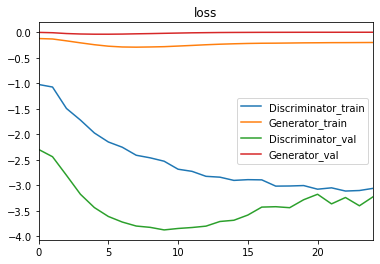

In [148]:
pd.DataFrame(np.array([[np.mean(x) for x in batches_losses_D], [np.mean(x) for x in batches_losses_G], [np.mean(x) for x in val_losses_D], [np.mean(x) for x in val_losses_G]]).T,
                   columns=['Discriminator_train', 'Generator_train', 'Discriminator_val', 'Generator_val']).plot(title="loss")

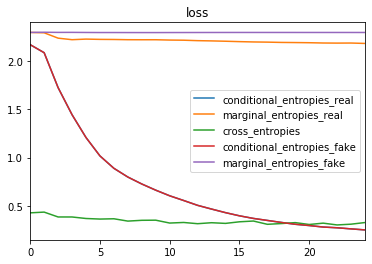

In [150]:
pd.DataFrame(np.array([[np.mean(x) for x in conditional_entropies_real], [np.mean(x) for x in marginal_entropies_real], [np.mean(x) for x in cross_entropies], [np.mean(x) for x in conditional_entropies_fake], [np.mean(x) for x in marginal_entropies_fake]]).T,
                   columns=['conditional_entropies_real', 'marginal_entropies_real', 'cross_entropies', 'conditional_entropies_fake', 'marginal_entropies_fake']).plot(title="loss")

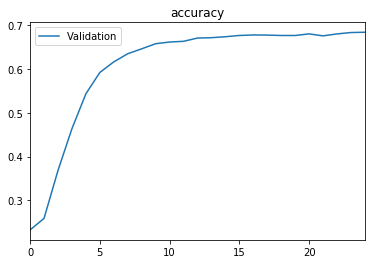

In [149]:
pd.DataFrame(np.array(val_acc).T,
                   columns=['Validation']).plot(title="accuracy")

In [152]:
print(f"maximal Accuracy of {round(max(val_acc),2)} on the epoch {np.argmax(val_acc)+1}")

maximal Accuracy of 0.68 on the epoch 25


# CatGAN with λ=5

In [153]:
TRAIN_BATCH_SIZE=100
EPOCH=25
validation_split = .2
shuffle_dataset = True
random_seed= 42
device="cpu"
lr=3e-5#1e-3
nb_training_label=100
nb_class=10
latent_size=100
λ=5
layer_dim=[784,1000,500,250,250,250,10]
learning_rate = 1e-3

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

print('Loading MNIST Dataset...')

dataset = MNIST('./data', transform=img_transform,train=True)# download=True)
mnist_dataset=MNIST_Dataset(dataset)

#train_size = int(0.8 * len(dataset))
#test_size = len(dataset) - train_size
#train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

idx_label=choose_label_rand(mnist_dataset, nb_training_label, nb_class, train_indices)
mnist_dataset.use_label_mask[idx_label]=True

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_data_loader=DataLoader(
    mnist_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=train_sampler)

valid_data_loader=DataLoader(
    mnist_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=valid_sampler)


num_training_steps=int(len(dataset) / TRAIN_BATCH_SIZE * EPOCH)

discriminator=Discriminator()
generator=Generator()
optimizer_G=AdamW(generator.parameters(), lr=lr)
optimizer_D=AdamW(discriminator.parameters(), lr=lr)
# optimizer=Adam(model.parameters(), lr=lr, weight_decay=1e-5)
# scheduler = get_linear_schedule_with_warmup(optimizer, 
#                                         num_warmup_steps = 0,
#                                         num_training_steps = num_training_steps)

val_losses_G=[]
val_losses_D=[]
batches_losses_D=[]
batches_losses_G=[]
val_acc=[]

conditional_entropies_real=[]
marginal_entropies_real=[]
cross_entropies=[]
conditional_entropies_fake=[]
marginal_entropies_fake=[]

val_conditional_entropies_real=[]
val_marginal_entropies_real=[]
val_cross_entropies=[]
val_conditional_entropies_fake=[]
val_marginal_entropies_fake=[]


for epoch in range(EPOCH):
    t0 = time.time()    
    print(f"\n=============== EPOCH {epoch+1} / {EPOCH} ===============\n")
    batches_losses_tmp_G, batches_losses_tmp_D, conditional_entropies_real_tmp, marginal_entropies_real_tmp, cross_entropies_tmp, conditional_entropies_fake_tmp, marginal_entropies_fake_tmp=train_loop_fun1(train_data_loader, discriminator, generator, optimizer_G, optimizer_D, latent_size, TRAIN_BATCH_SIZE, device, λ)
    epoch_loss_D=np.mean(batches_losses_tmp_D)
    epoch_loss_G=np.mean(batches_losses_tmp_G)
    print(f"\n*** avg_Generator_loss : {epoch_loss_G:.2f}, avg_Discriminator_loss : {epoch_loss_D:.2f}, time : ~{(time.time()-t0)//60} min ({time.time()-t0:.2f} sec) ***\n")
    t1=time.time()
    output, target, val_losses_tmp_D, val_losses_tmp_G, val_conditional_entropies_real_tmp, val_marginal_entropies_real_tmp, val_cross_entropies_tmp, val_conditional_entropies_fake_tmp, val_marginal_entropies_fake_tmp=eval_loop_fun1(valid_data_loader, discriminator, generator, latent_size, TRAIN_BATCH_SIZE, device, λ)
    print(f"==> evaluation : avg_Generator_loss = {np.mean(val_losses_tmp_G):.2f}, avg_Discriminator_loss = {np.mean(val_losses_tmp_D):.2f}, time : {time.time()-t1:.2f} sec\n")
    tmp_evaluate=evaluate(target.reshape(-1), output)
    print(f"=====>\t{tmp_evaluate}")
    
    val_acc.append(tmp_evaluate['accuracy'])
    val_losses_D.append(val_losses_tmp_D)
    val_losses_G.append(val_losses_tmp_G)
    batches_losses_D.append(batches_losses_tmp_D)
    batches_losses_G.append(batches_losses_tmp_G)
    
    conditional_entropies_real.append(conditional_entropies_real_tmp)
    marginal_entropies_real.append(marginal_entropies_real_tmp)
    cross_entropies.append(cross_entropies_tmp)
    conditional_entropies_fake.append(conditional_entropies_fake_tmp)
    marginal_entropies_fake.append(marginal_entropies_fake_tmp)

    val_conditional_entropies_real.append(val_conditional_entropies_real_tmp)
    val_marginal_entropies_real.append(val_marginal_entropies_real_tmp)
    val_cross_entropies.append(val_cross_entropies_tmp)
    val_conditional_entropies_fake.append(val_conditional_entropies_fake_tmp)
    val_marginal_entropies_fake.append(val_marginal_entropies_fake_tmp)
    
    print(f"\t§§ CatGAN model has been saved §§")
    torch.save(discriminator, f"mnist/CatGAN/discriminator/CatGAN_discriminator_model_epoch{epoch+1}.pt")
    torch.save(generator, f"mnist/CatGAN/generator/CatGAN_generator_model_epoch{epoch+1}.pt")    

Loading MNIST Dataset...
Choosing Random index for the class 0
Choosing Random index for the class 1
Choosing Random index for the class 2
Choosing Random index for the class 3
Choosing Random index for the class 4
Choosing Random index for the class 5
Choosing Random index for the class 6
Choosing Random index for the class 7
Choosing Random index for the class 8
Choosing Random index for the class 9

=============== EPOCH 1 / 25 ===============

___ batch index = 0 / 480 (0.00%), time = 0.47 secondes ___
	Discriminator loss = 9.44, H_x[p(y|D)] : 2.27, E[H[p(y|x,D)]] : 2.13, λE[CE[y,p(y|x,D)]]:10.65
	Generator loss = -0.12, H_G[p(y|D)] : 2.27, E[H[p(y|G(z),D)]]: 2.13
___ batch index = 150 / 480 (31.25%), time = 67.68 secondes ___
	Discriminator loss = -0.07, H_x[p(y|D)] : 2.29, E[H[p(y|x,D)]] : 2.16, λE[CE[y,p(y|x,D)]]:10.81
	Generator loss = -0.13, H_G[p(y|D)] : 2.29, E[H[p(y|G(z),D)]]: 2.16
___ batch index = 300 / 480 (62.50%), time = 70.68 secondes ___
	Discriminator loss = -0.30, 

___ batch index = 0 / 480 (0.00%), time = 0.42 secondes ___
	Discriminator loss = 4.26, H_x[p(y|D)] : 2.23, E[H[p(y|x,D)]] : 1.16, λE[CE[y,p(y|x,D)]]:5.79
	Generator loss = -0.27, H_G[p(y|D)] : 2.30, E[H[p(y|G(z),D)]]: 1.16
___ batch index = 150 / 480 (31.25%), time = 75.20 secondes ___
	Discriminator loss = -1.64, H_x[p(y|D)] : 2.23, E[H[p(y|x,D)]] : 1.14, λE[CE[y,p(y|x,D)]]:5.68
	Generator loss = -0.29, H_G[p(y|D)] : 2.30, E[H[p(y|G(z),D)]]: 1.14
___ batch index = 300 / 480 (62.50%), time = 71.73 secondes ___
	Discriminator loss = -1.43, H_x[p(y|D)] : 2.23, E[H[p(y|x,D)]] : 1.11, λE[CE[y,p(y|x,D)]]:5.57
	Generator loss = -0.29, H_G[p(y|D)] : 2.30, E[H[p(y|G(z),D)]]: 1.11
___ batch index = 450 / 480 (93.75%), time = 73.66 secondes ___
	Discriminator loss = -1.31, H_x[p(y|D)] : 2.23, E[H[p(y|x,D)]] : 1.07, λE[CE[y,p(y|x,D)]]:5.33
	Generator loss = -0.30, H_G[p(y|D)] : 2.30, E[H[p(y|G(z),D)]]: 1.07

*** avg_Generator_loss : -0.29, avg_Discriminator_loss : -1.42, time : ~3.0 min (235.00 

___ batch index = 300 / 480 (62.50%), time = 73.49 secondes ___
	Discriminator loss = -2.04, H_x[p(y|D)] : 2.23, E[H[p(y|x,D)]] : 0.71, λE[CE[y,p(y|x,D)]]:3.57
	Generator loss = -0.33, H_G[p(y|D)] : 2.30, E[H[p(y|G(z),D)]]: 0.71
___ batch index = 450 / 480 (93.75%), time = 72.84 secondes ___
	Discriminator loss = -2.07, H_x[p(y|D)] : 2.23, E[H[p(y|x,D)]] : 0.69, λE[CE[y,p(y|x,D)]]:3.47
	Generator loss = -0.32, H_G[p(y|D)] : 2.30, E[H[p(y|G(z),D)]]: 0.69

*** avg_Generator_loss : -0.32, avg_Discriminator_loss : -1.88, time : ~3.0 min (229.47 sec) ***

==> evaluation : avg_Generator_loss = -0.04, avg_Discriminator_loss = -3.82, time : 20.25 sec

=====>	{'accuracy': 0.6883333333333334, 'nb exemple': 12000, 'true_prediction': 8260, 'false_prediction': 3740}
	§§ CatGAN model has been saved §§

=============== EPOCH 14 / 25 ===============

___ batch index = 0 / 480 (0.00%), time = 0.42 secondes ___
	Discriminator loss = -3.48, H_x[p(y|D)] : 2.24, E[H[p(y|x,D)]] : 0.72, λE[CE[y,p(y|x,D)]]:3.


*** avg_Generator_loss : -0.28, avg_Discriminator_loss : -2.14, time : ~4.0 min (241.93 sec) ***

==> evaluation : avg_Generator_loss = -0.02, avg_Discriminator_loss = -3.85, time : 18.97 sec

=====>	{'accuracy': 0.70225, 'nb exemple': 12000, 'true_prediction': 8427, 'false_prediction': 3573}
	§§ CatGAN model has been saved §§

=============== EPOCH 20 / 25 ===============

___ batch index = 0 / 480 (0.00%), time = 0.46 secondes ___
	Discriminator loss = -3.82, H_x[p(y|D)] : 2.21, E[H[p(y|x,D)]] : 0.43, λE[CE[y,p(y|x,D)]]:2.15
	Generator loss = -0.26, H_G[p(y|D)] : 2.30, E[H[p(y|G(z),D)]]: 0.43
___ batch index = 150 / 480 (31.25%), time = 72.87 secondes ___
	Discriminator loss = -1.97, H_x[p(y|D)] : 2.23, E[H[p(y|x,D)]] : 0.50, λE[CE[y,p(y|x,D)]]:2.48
	Generator loss = -0.28, H_G[p(y|D)] : 2.30, E[H[p(y|G(z),D)]]: 0.50
___ batch index = 300 / 480 (62.50%), time = 72.76 secondes ___
	Discriminator loss = -2.53, H_x[p(y|D)] : 2.23, E[H[p(y|x,D)]] : 0.48, λE[CE[y,p(y|x,D)]]:2.42
	Generat

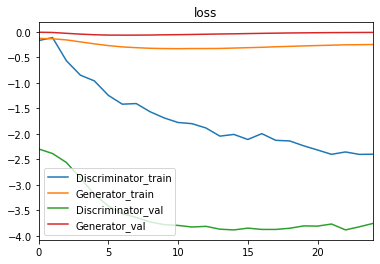

In [154]:
pd.DataFrame(np.array([[np.mean(x) for x in batches_losses_D], [np.mean(x) for x in batches_losses_G], [np.mean(x) for x in val_losses_D], [np.mean(x) for x in val_losses_G]]).T,
                   columns=['Discriminator_train', 'Generator_train', 'Discriminator_val', 'Generator_val']).plot(title="loss")

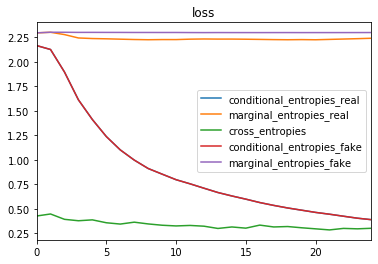

In [156]:
pd.DataFrame(np.array([[np.mean(x) for x in conditional_entropies_real], [np.mean(x) for x in marginal_entropies_real], [np.mean(x) for x in cross_entropies], [np.mean(x) for x in conditional_entropies_fake], [np.mean(x) for x in marginal_entropies_fake]]).T,
                   columns=['conditional_entropies_real', 'marginal_entropies_real', 'cross_entropies', 'conditional_entropies_fake', 'marginal_entropies_fake']).plot(title="loss")

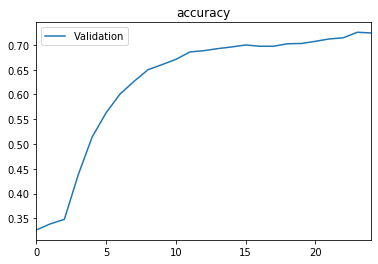

In [155]:
pd.DataFrame(np.array(val_acc).T,
                   columns=['Validation']).plot(title="accuracy")

In [157]:
print(f"maximal Accuracy of {round(max(val_acc),2)} on the epoch {np.argmax(val_acc)+1}")

maximal Accuracy of 0.73 on the epoch 24


In [161]:
# test on MNIST

generator_model_test=torch.load("./mnist/CatGAN/generator/CatGAN_generator_model_epoch24.pt")
discriminator_model_test=torch.load("./mnist/CatGAN/discriminator/CatGAN_discriminator_model_epoch24.pt")
test_losses=[]
test_acc=[]
t1=time.time()
test_dataset = MNIST('./data', transform=img_transform,train=False)# download=True)
test_mnist_dataset=MNIST_Dataset(test_dataset)
test_data_loader=DataLoader(
    test_mnist_dataset,
    batch_size=TRAIN_BATCH_SIZE)
output, target, test_losses_D, test_losses_G, test_conditional_entropies_real, test_marginal_entropies_real, test_cross_entropies, test_conditional_entropies_fake, test_marginal_entropies_fake=eval_loop_fun1(test_data_loader, discriminator_model_test, generator_model_test, latent_size, TRAIN_BATCH_SIZE, device, λ)
print(f"==> evaluation : avg_discriminator_loss = {np.mean(test_losses_D):.2f}, avg_generator_loss = {np.mean(test_losses_G):.2f}, time : {time.time()-t1:.2f} sec\n")
test_evaluate=evaluate(target.reshape(-1), output)
print(f"=====>\t{test_evaluate}")
# test_acc.append(test_evaluate['accuracy'])
# test_losses.append(test_losses_D, test_losses_G)

==> evaluation : avg_discriminator_loss = -3.82, avg_generator_loss = -0.01, time : 18.26 sec

=====>	{'accuracy': 0.7409, 'nb exemple': 10000, 'true_prediction': 7409, 'false_prediction': 2591}
